### erddapy example for PMEL tools - Drifters and Alamo Floats (2018)

__pyversion__==3.6   
__author__==S.Bell

### connecting and basic information

In [145]:
from erddapy import ERDDAP
import pandas as pd
import numpy as np
import datetime

server_url='http://downdraft.pmel.noaa.gov:8080/erddap'
e = ERDDAP(server=server_url)

Get only ARGOS Drifter datafiles

In [170]:
df = pd.read_csv(e.get_search_url(response='csv', search_for='alamo'))
df_d = pd.read_csv(e.get_search_url(response='csv', search_for='2018_Argos drifter'))

In [171]:
argos = df['Dataset ID'].values
print(argos)

['arctic_heat_alamo_profiles_11010' 'arctic_heat_alamo_profiles_9058'
 'arctic_heat_alamo_profiles_9076' 'arctic_heat_alamo_profiles_9085'
 'arctic_heat_alamo_profiles_9115' 'arctic_heat_alamo_profiles_9116'
 'arctic_heat_alamo_profiles_9117' 'arctic_heat_alamo_profiles_9119'
 'arctic_heat_alamo_profiles_9150' 'arctic_heat_alamo_profiles_9152'
 'arctic_heat_alamo_profiles_9153' 'arctic_heat_alamo_profiles_9199']


In [172]:
drifter = df_d['Dataset ID'].values
print(drifter)

['2018_Argos_Drifters_NRT']


In [173]:
kw = {
    'standard_name': 'sea_water_temperature',
    'min_lon': -360,
    'max_lon': 540,
    'min_lat': 50.0,
    'max_lat': 90.0,
    'min_time': '2018-01-10T00:00:00Z',
    'max_time': '2019-01-10T00:00:00Z'
}

In [174]:
variables = [e.get_var_by_attr(dataset_id=float, long_name=lambda v: v is not None) for float in argos]
variables_2 = [e.get_var_by_attr(dataset_id=drifterid, long_name=lambda v: v is not None) for drifterid in drifter]

In [175]:
common_variables = set(variables[0]).intersection(*variables[1:])
common_variables_2 = set(variables_2[0]).intersection(*variables_2[1:])

common_variables.update(['profileid']) 
common_variables_2.update(['trajectory_id']) 
common_variables

{'CYCLE_NUMBER',
 'FLOAT_SERIAL_NO',
 'PRES',
 'REFERENCE_DATE_TIME',
 'TEMP',
 'latitude',
 'longitude',
 'profileid',
 'time'}

In [176]:
constraints = {
    'longitude>=': kw['min_lon'],
    'longitude<=': kw['max_lon'],
    'latitude>=': kw['min_lat'],
    'latitude<=': kw['max_lat'],
    'time>=': kw['min_time'],
    'time<=': kw['max_time'],
}

download_url = e.get_download_url(
    dataset_id=argos[0],
    protocol='tabledap',
    response='csv',
    variables=common_variables,
    constraints=constraints
)

print(download_url)



http://downdraft.pmel.noaa.gov:8080/erddap/tabledap/arctic_heat_alamo_profiles_11010.csv?PRES,CYCLE_NUMBER,FLOAT_SERIAL_NO,longitude,REFERENCE_DATE_TIME,time,TEMP,latitude,profileid&longitude>=-360&longitude<=540&latitude>=50.0&latitude<=90.0&time>=1515542400.0&time<=1547078400.0


In [245]:
from requests.exceptions import HTTPError

dfs = {}
for arfloat in argos:
    print(arfloat)
    try:
        e = ERDDAP(server=server_url,
            protocol='tabledap',
            response='csv'
        )
        e.constraints=constraints
        e.variables=common_variables
        e.dataset_id=arfloat
    except HTTPError:
        print('Failed to generate url {}'.format(alamo))
        continue
    try:
        dftemp = e.to_pandas(
                            index_col='time (UTC)',
                            parse_dates=True,
                            skiprows=(1,)  # units information can be dropped.
                            )
        dftemp.columns = [x[1].split()[0] for x in enumerate(dftemp.columns)]
        dfs.update({arfloat: dftemp})
    except:
        pass

arctic_heat_alamo_profiles_11010
arctic_heat_alamo_profiles_9058
arctic_heat_alamo_profiles_9076
arctic_heat_alamo_profiles_9085
arctic_heat_alamo_profiles_9115
arctic_heat_alamo_profiles_9116
arctic_heat_alamo_profiles_9117
arctic_heat_alamo_profiles_9119
arctic_heat_alamo_profiles_9150
arctic_heat_alamo_profiles_9152
arctic_heat_alamo_profiles_9153
arctic_heat_alamo_profiles_9199


In [178]:
constraints = {
    'longitude>=': kw['min_lon'],
    'longitude<=': kw['max_lon'],
    'latitude>=': kw['min_lat'],
    'latitude<=': kw['max_lat'],
    'time>=': kw['min_time'],
    'time<=': kw['max_time'],
}

try:
    download_url = e.get_download_url(
        protocol='tabledap',
        response='csv',
    )
    e.variables=common_variables_2,
    e.constraints=constraints
    e.dataset_id=drifter[0],

    print(download_url)
except HTTPError:
    print("Failed to Download from URL")


http://downdraft.pmel.noaa.gov:8080/erddap/tabledap/arctic_heat_alamo_profiles_9199.csv?PRES,CYCLE_NUMBER,FLOAT_SERIAL_NO,longitude,REFERENCE_DATE_TIME,time,TEMP,latitude,profileid&longitude>=-360&longitude<=540&latitude>=50.0&latitude<=90.0&time>=1515542400.0&time<=1547078400.0


In [179]:
from requests.exceptions import HTTPError

dfs_2 = {}
for arfloat in drifter:
    print(arfloat)
    try:
        e = ERDDAP(server=server_url,
            protocol='tabledap',
            response='csv'
        )
        e.constraints=constraints
        e.variables=common_variables_2
        e.dataset_id=arfloat
    except HTTPError:
        print('Failed to generate url {}'.format(alamo))
        continue
    try:
        dftemp = e.to_pandas(
                            index_col='time (UTC)',
                            parse_dates=True,
                            skiprows=(1,)  # units information can be dropped.
                            )
        dftemp.columns = [x[1].split()[0] for x in enumerate(dftemp.columns)]
        dfs_2.update({arfloat: dftemp})
    except:
        pass

2018_Argos_Drifters_NRT


#### weekly average northward movement

- or weekly averaged net movement

In [305]:
dfg = dfs_2['2018_Argos_Drifters_NRT'].groupby('trajectory_id')
dfg.groups.keys()

for i in range(1,7):
    for traj in dfg.groups.keys():
        print(traj,f"week {i}")
        try:
            print(dfg.get_group(traj).resample('3H').mean()[datetime.date(2018,8,1)+datetime.timedelta(days=7*(i-1)):datetime.date(2018,8,1)+datetime.timedelta(days=7*i)].iloc[0].latitude)
            print(dfg.get_group(traj).resample('3H').mean()[datetime.date(2018,8,1)+datetime.timedelta(days=7*(i-1)):datetime.date(2018,8,1)+datetime.timedelta(days=7*i)].iloc[-1].latitude)
        except:
            print("nodata")
            print("nodata")            

136863 week 1
62.50600000000001
62.72239999999999
136866 week 1
63.97985714285714
63.977
136867 week 1
51.364000000000004
51.1836
136868 week 1
nodata
nodata
139910 week 1
70.12674999999999
70.44
139911 week 1
69.82942857142856
69.80166666666666
139912 week 1
nan
69.127
139913 week 1
nodata
nodata
139914 week 1
nodata
nodata
139915 week 1
nodata
nodata
145469 week 1
60.077666666666666
60.32116666666667
145473 week 1
60.011714285714284
60.05566666666667
145474 week 1
nodata
nodata
145480 week 1
60.15271428571428
60.3702
148276 week 1
53.948499999999996
54.467
136863 week 2
62.72239999999999
62.53528571428571
136866 week 2
63.977
63.903999999999996
136867 week 2
51.1836
51.141999999999996
136868 week 2
nodata
nodata
139910 week 2
70.44
70.35711111111112
139911 week 2
69.80166666666666
69.61022222222222
139912 week 2
69.127
69.14257142857142
139913 week 2
71.83000000000001
71.740125
139914 week 2
71.211
71.11099999999999
139915 week 2
70.81099999999999
70.7988888888889
145469 week 2
60.32

53.948499999999996

### Plots below:

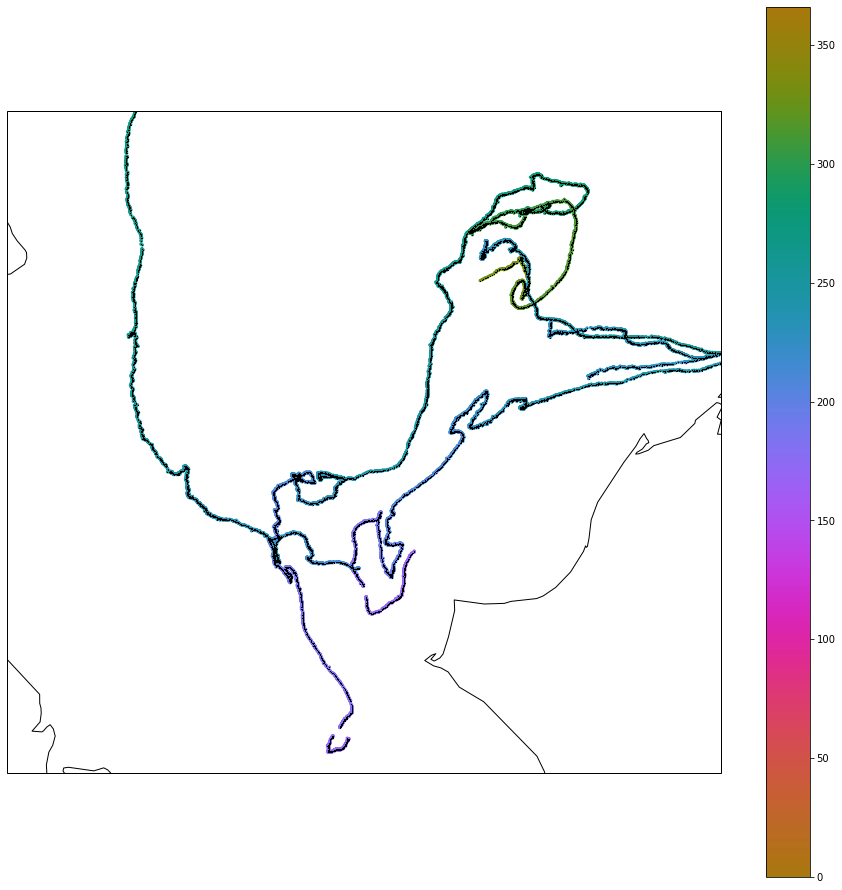

In [156]:

projection=ccrs.LambertConformal(central_longitude=-160.0)
transformation=ccrs.PlateCarree()

land_50m = cfeature.NaturalEarthFeature('physical', 'land', '50m',
                                        edgecolor='face',
                                        facecolor='1.0')

dx = dy = 0.5
extent = [-176, -160, 67.5, 72.5]

fig,ax,plt = make_map(projection=projection)

'''
for alamo, df in dfs.items():
    ax.plot(df['longitude'][0], df['latitude'][0], 'or', markersize=5., label=alamo, transform=transformation)
    ax.plot(df['longitude'], df['latitude'], '+k', markersize=0.5, label=alamo, transform=transformation)
    t = ax.scatter(df['longitude'], df['latitude'], s=5,c=df.index.dayofyear, cmap=cmocean.cm.phase, vmin=0, vmax=366, label=alamo, transform=transformation)
'''

for alamo, df in dfs_2.items():
    ax.plot(df['longitude'][0], df['latitude'][0], 'or', markersize=5., label=alamo, transform=transformation)
    ax.plot(df['longitude'], df['latitude'], '+k', markersize=0.5, label=alamo, transform=transformation)
    t = ax.scatter(df['longitude'], df['latitude'], s=5,c=df.index.dayofyear, cmap=cmocean.cm.phase, vmin=0, vmax=366, label=alamo, transform=transformation)

plt.colorbar(t)
#leg = ax.legend()

ax.add_feature(land_50m)
ax.coastlines(resolution='50m')
ax.set_extent(extent)

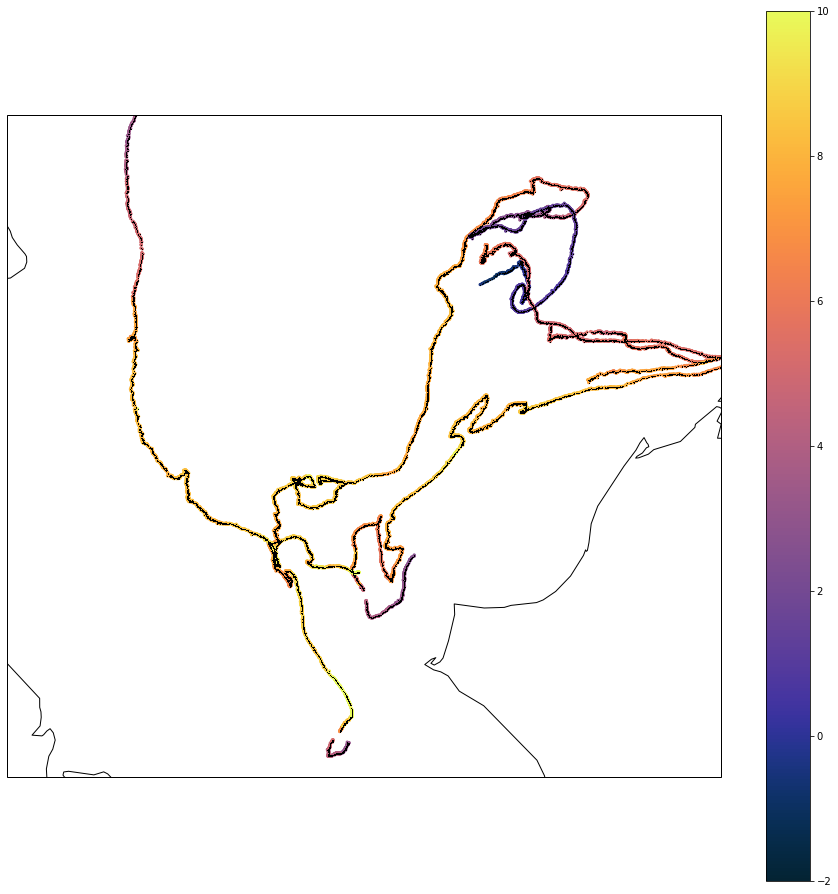

In [181]:
projection=ccrs.LambertConformal(central_longitude=-160.0)
transformation=ccrs.PlateCarree()

land_50m = cfeature.NaturalEarthFeature('physical', 'land', '50m',
                                        edgecolor='face',
                                        facecolor='1.0')

dx = dy = 0.5
extent = [-176, -160, 67.5, 72.5]

fig,ax,plt = make_map(projection=projection)

for alamo, df in dfs_2.items():
    #ax.scatter(df_sub['longitude'], df_sub['latitude'], s=5, color='r', label=alamo, transform=transformation)
    ax.plot(df['longitude'], df['latitude'], '+k', markersize=0.5, label=alamo, transform=transformation)
    t = ax.scatter(df['longitude'], df['latitude'], s=5,c=df.sst, cmap=cmocean.cm.thermal, vmin=-2, vmax=10, label=alamo, transform=transformation)

plt.colorbar(t)
#leg = ax.legend()

ax.add_feature(land_50m)
ax.coastlines(resolution='50m')
ax.set_extent(extent)

In [182]:
df.tail()

,latitude,trajectory_id,sst,longitude,strain,voltage
time (UTC),,,,,,
2018-12-31 21:11:00+00:00,53.820,148276,4.36,189.297,0.0,9.8
2018-12-31 21:15:00+00:00,53.817,148276,4.36,189.297,0.0,9.8
2018-12-31 21:44:00+00:00,53.820,148276,4.36,189.293,0.0,9.8
2018-12-31 21:57:00+00:00,53.819,148276,4.36,189.289,1.0,9.8
2018-12-31 23:33:00+00:00,53.832,148276,4.36,189.285,1.0,9.8


In [183]:
t=df.groupby('trajectory_id')
t.groups.keys()

dict_keys([136863, 136866, 136867, 136868, 139910, 139911, 139912, 139913, 139914, 139915, 145469, 145473, 145474, 145480, 148276])

# Using Python-GMT

In [184]:
import pygmt as gmt

In [185]:
fig = gmt.Figure()

fig.coast(region=[-175, -155, 65, 75], projection='B-165/60/55/60/6i', land='lightgray', water='gray',
          frame=True,U=True)

In [186]:
dfs_2['2018_Argos_Drifters_NRT'].groupby('trajectory_id').count()

,latitude,sst,longitude,strain,voltage
trajectory_id,,,,,
136863,10158,10158,10158,10158,10158
136866,5836,5836,5836,5836,5836
136867,5449,5449,5449,5449,5449
136868,105,105,105,105,105
139910,4907,4907,4907,4907,4907
139911,8614,8614,8614,8614,8614
139912,7112,7112,7112,7112,7112
139913,5087,5087,5087,5087,5087
139914,1783,1783,1783,1783,1783


In [187]:
dfg = dfs_2['2018_Argos_Drifters_NRT'].groupby('trajectory_id')
dfg.groups.keys()

dict_keys([136863, 136866, 136867, 136868, 139910, 139911, 139912, 139913, 139914, 139915, 145469, 145473, 145474, 145480, 148276])

In [188]:
#color by id for one year
clist=['red','black','blue','green','cyan','yellow','orange','lightred','lightgray',
      'lightblue','lightgreen','lightyellow','brown','darkgray','darkred','darkblue']
count=0
for traj in dfg.groups.keys():
    fig.plot(x=dfg.get_group(traj).longitude, y=dfg.get_group(traj).latitude, color=clist[count], style='p0.05')
    print(clist[count])
    count+=1

red
black
blue
green
cyan
yellow
orange
lightred
lightgray
lightblue
lightgreen
lightyellow
brown
darkgray
darkred


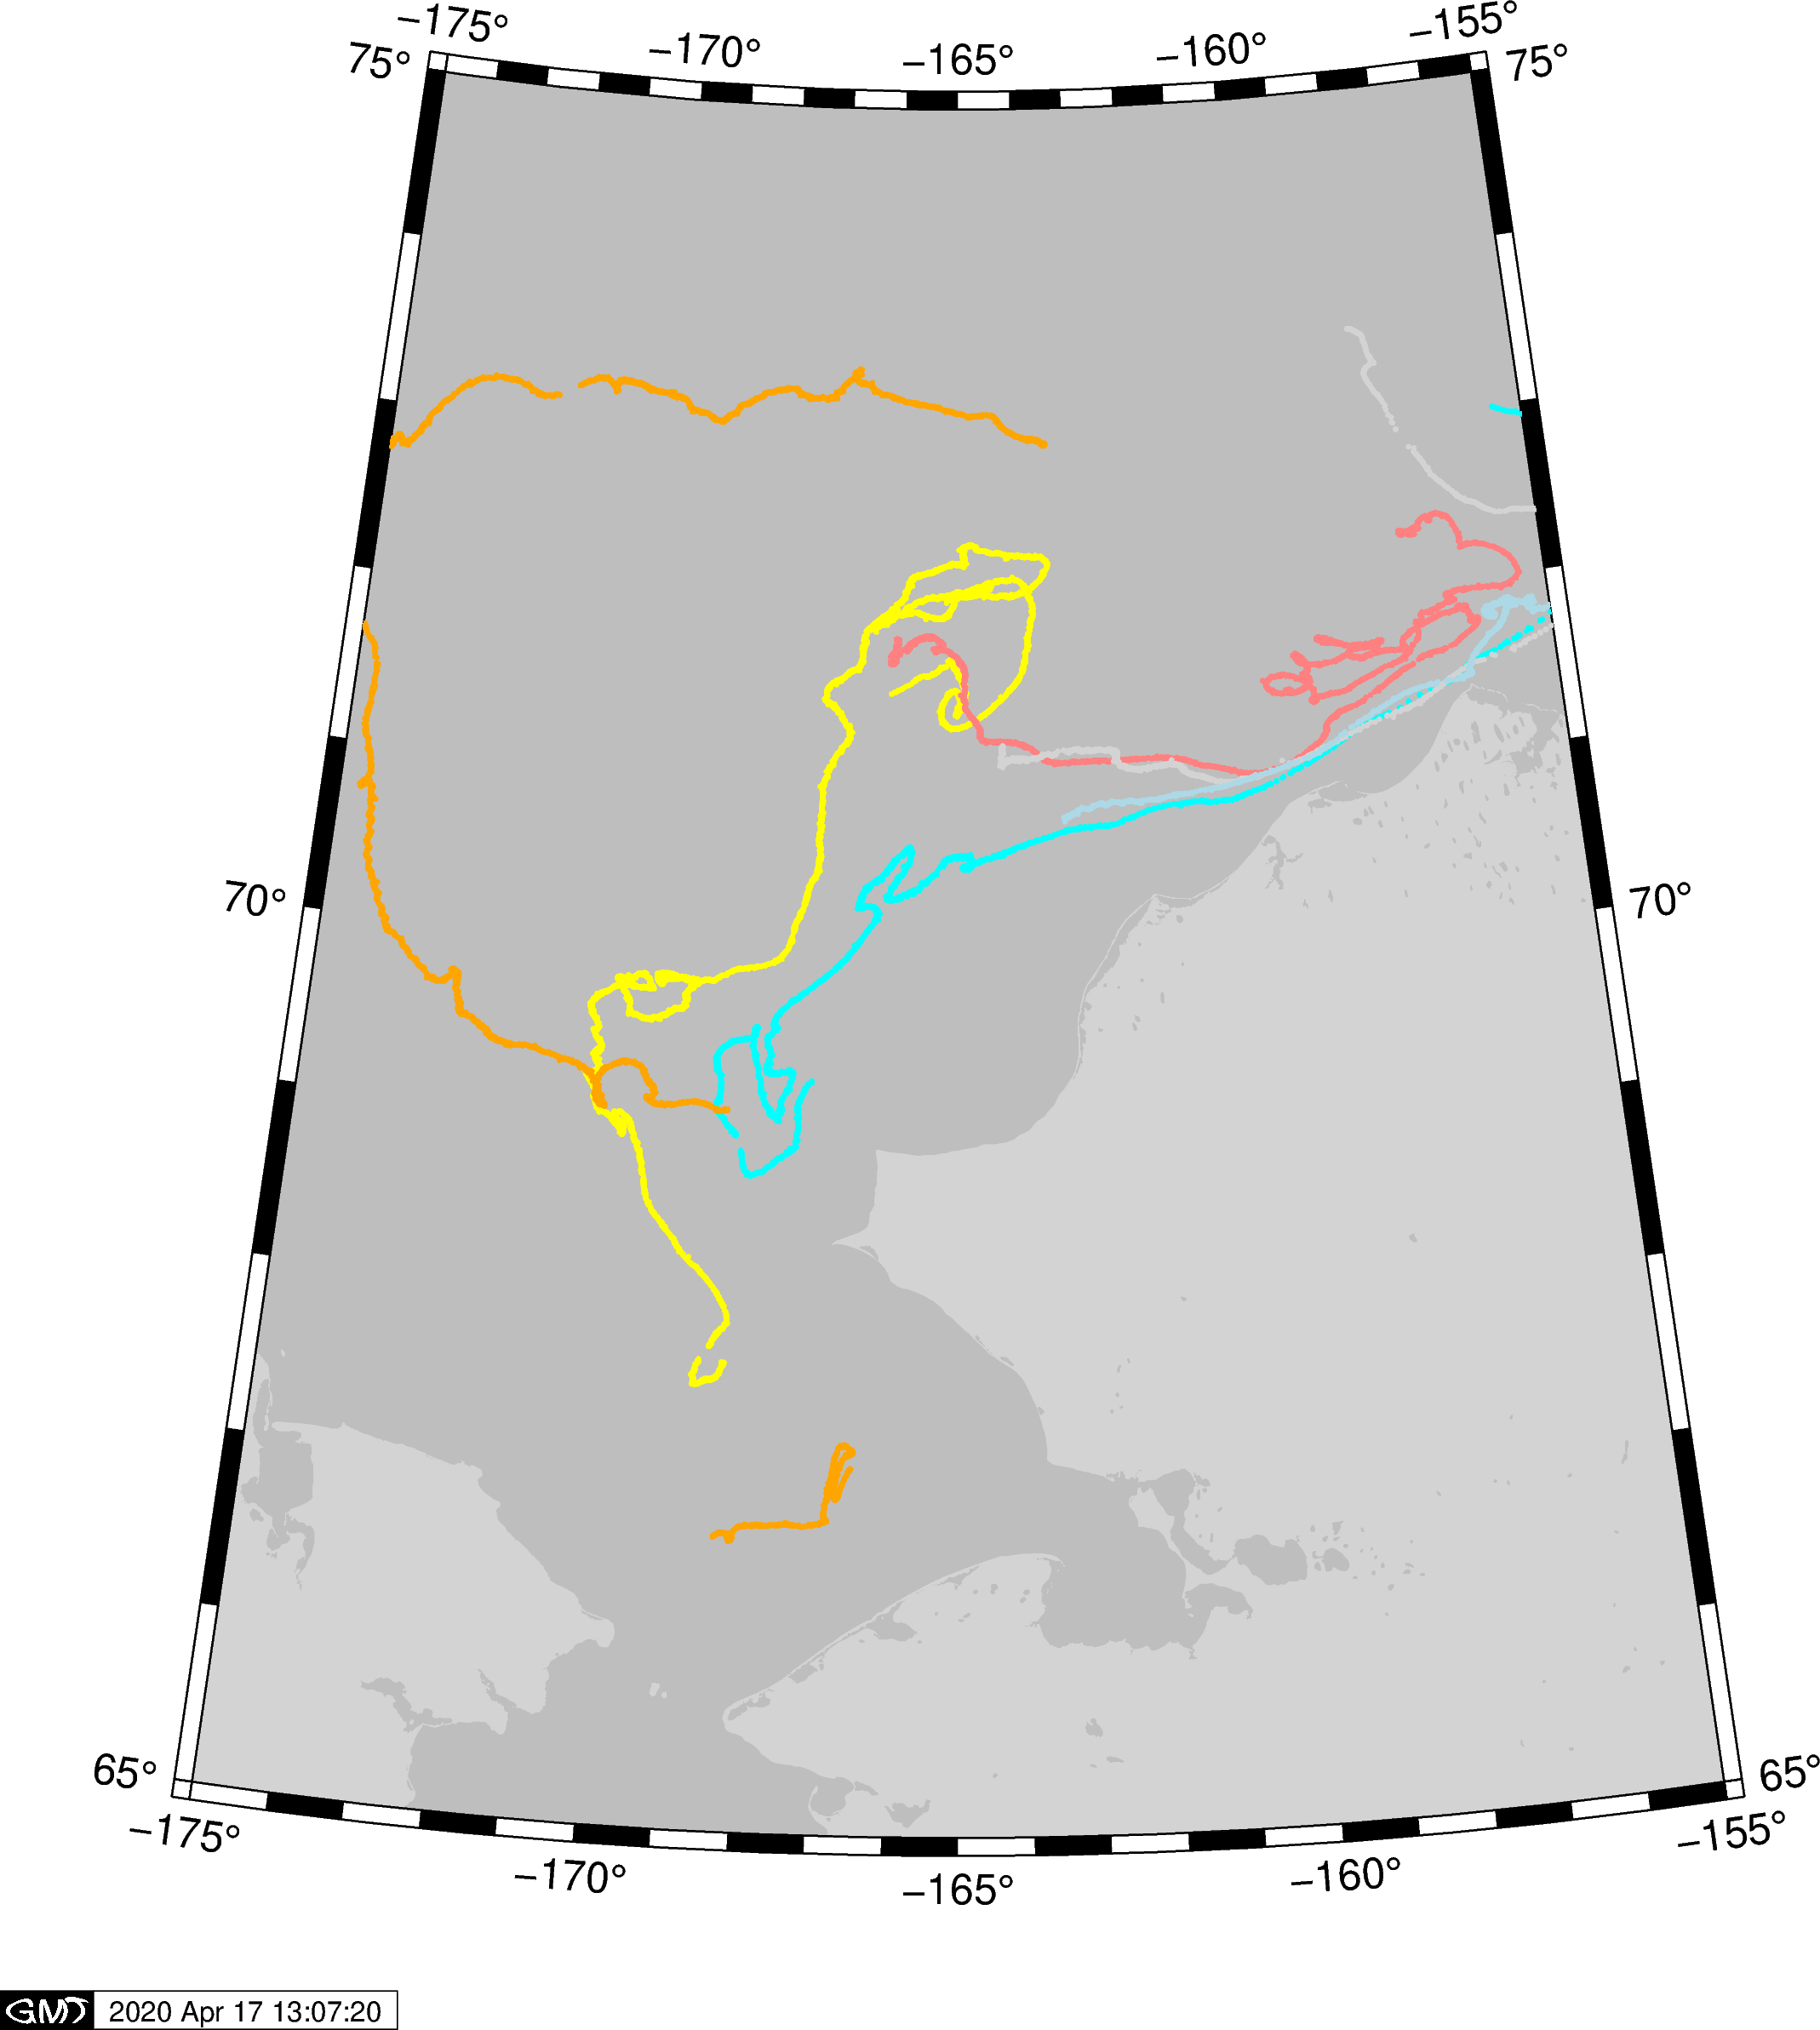

In [189]:
fig.show()

In [235]:
fig1 = gmt.Figure()
fig1.coast(region=[-175, -150, 65, 75], projection='B-162.5/60/55/60/6i', land='lightgray', water='gray',
          frame=True,U=False)

fig1b = gmt.Figure()
fig1b.coast(region=[-185, -160, 50, 65], projection='B-172.5/60/55/60/6i', land='lightgray', water='gray',
          frame=True,U=True)

In [269]:
#color by sst
for ship, df in dfs_2.items():
    #choose temp boundaries
    dfmiss = df.copy()
    dfmiss.sst.loc[(df.sst > 15) | (df.sst <-2)] = np.nan
    # normalize data for colormap
    dfnorm = dfmiss.apply(lambda x: (x - (-2)) / (15 - (-2)))
    fig1.plot(x=dfmiss.longitude, y=dfmiss.latitude, color=256*dfnorm.sst, cmap='thermal', style='c0.05c')

#color by sst
for ship, df in dfs_2.items():
    #choose temp boundaries
    dfmiss = df.copy()
    dfmiss.sst.loc[(df.sst > 15) | (df.sst <-2)] = np.nan
    # normalize data for colormap
    dfnorm = dfmiss.apply(lambda x: (x - (-2)) / (15 - (-2)))
    fig1b.plot(x=dfmiss.longitude, y=dfmiss.latitude, color=256*dfnorm.sst, cmap='thermal', style='c0.05c')


## GMT - SST Arctic

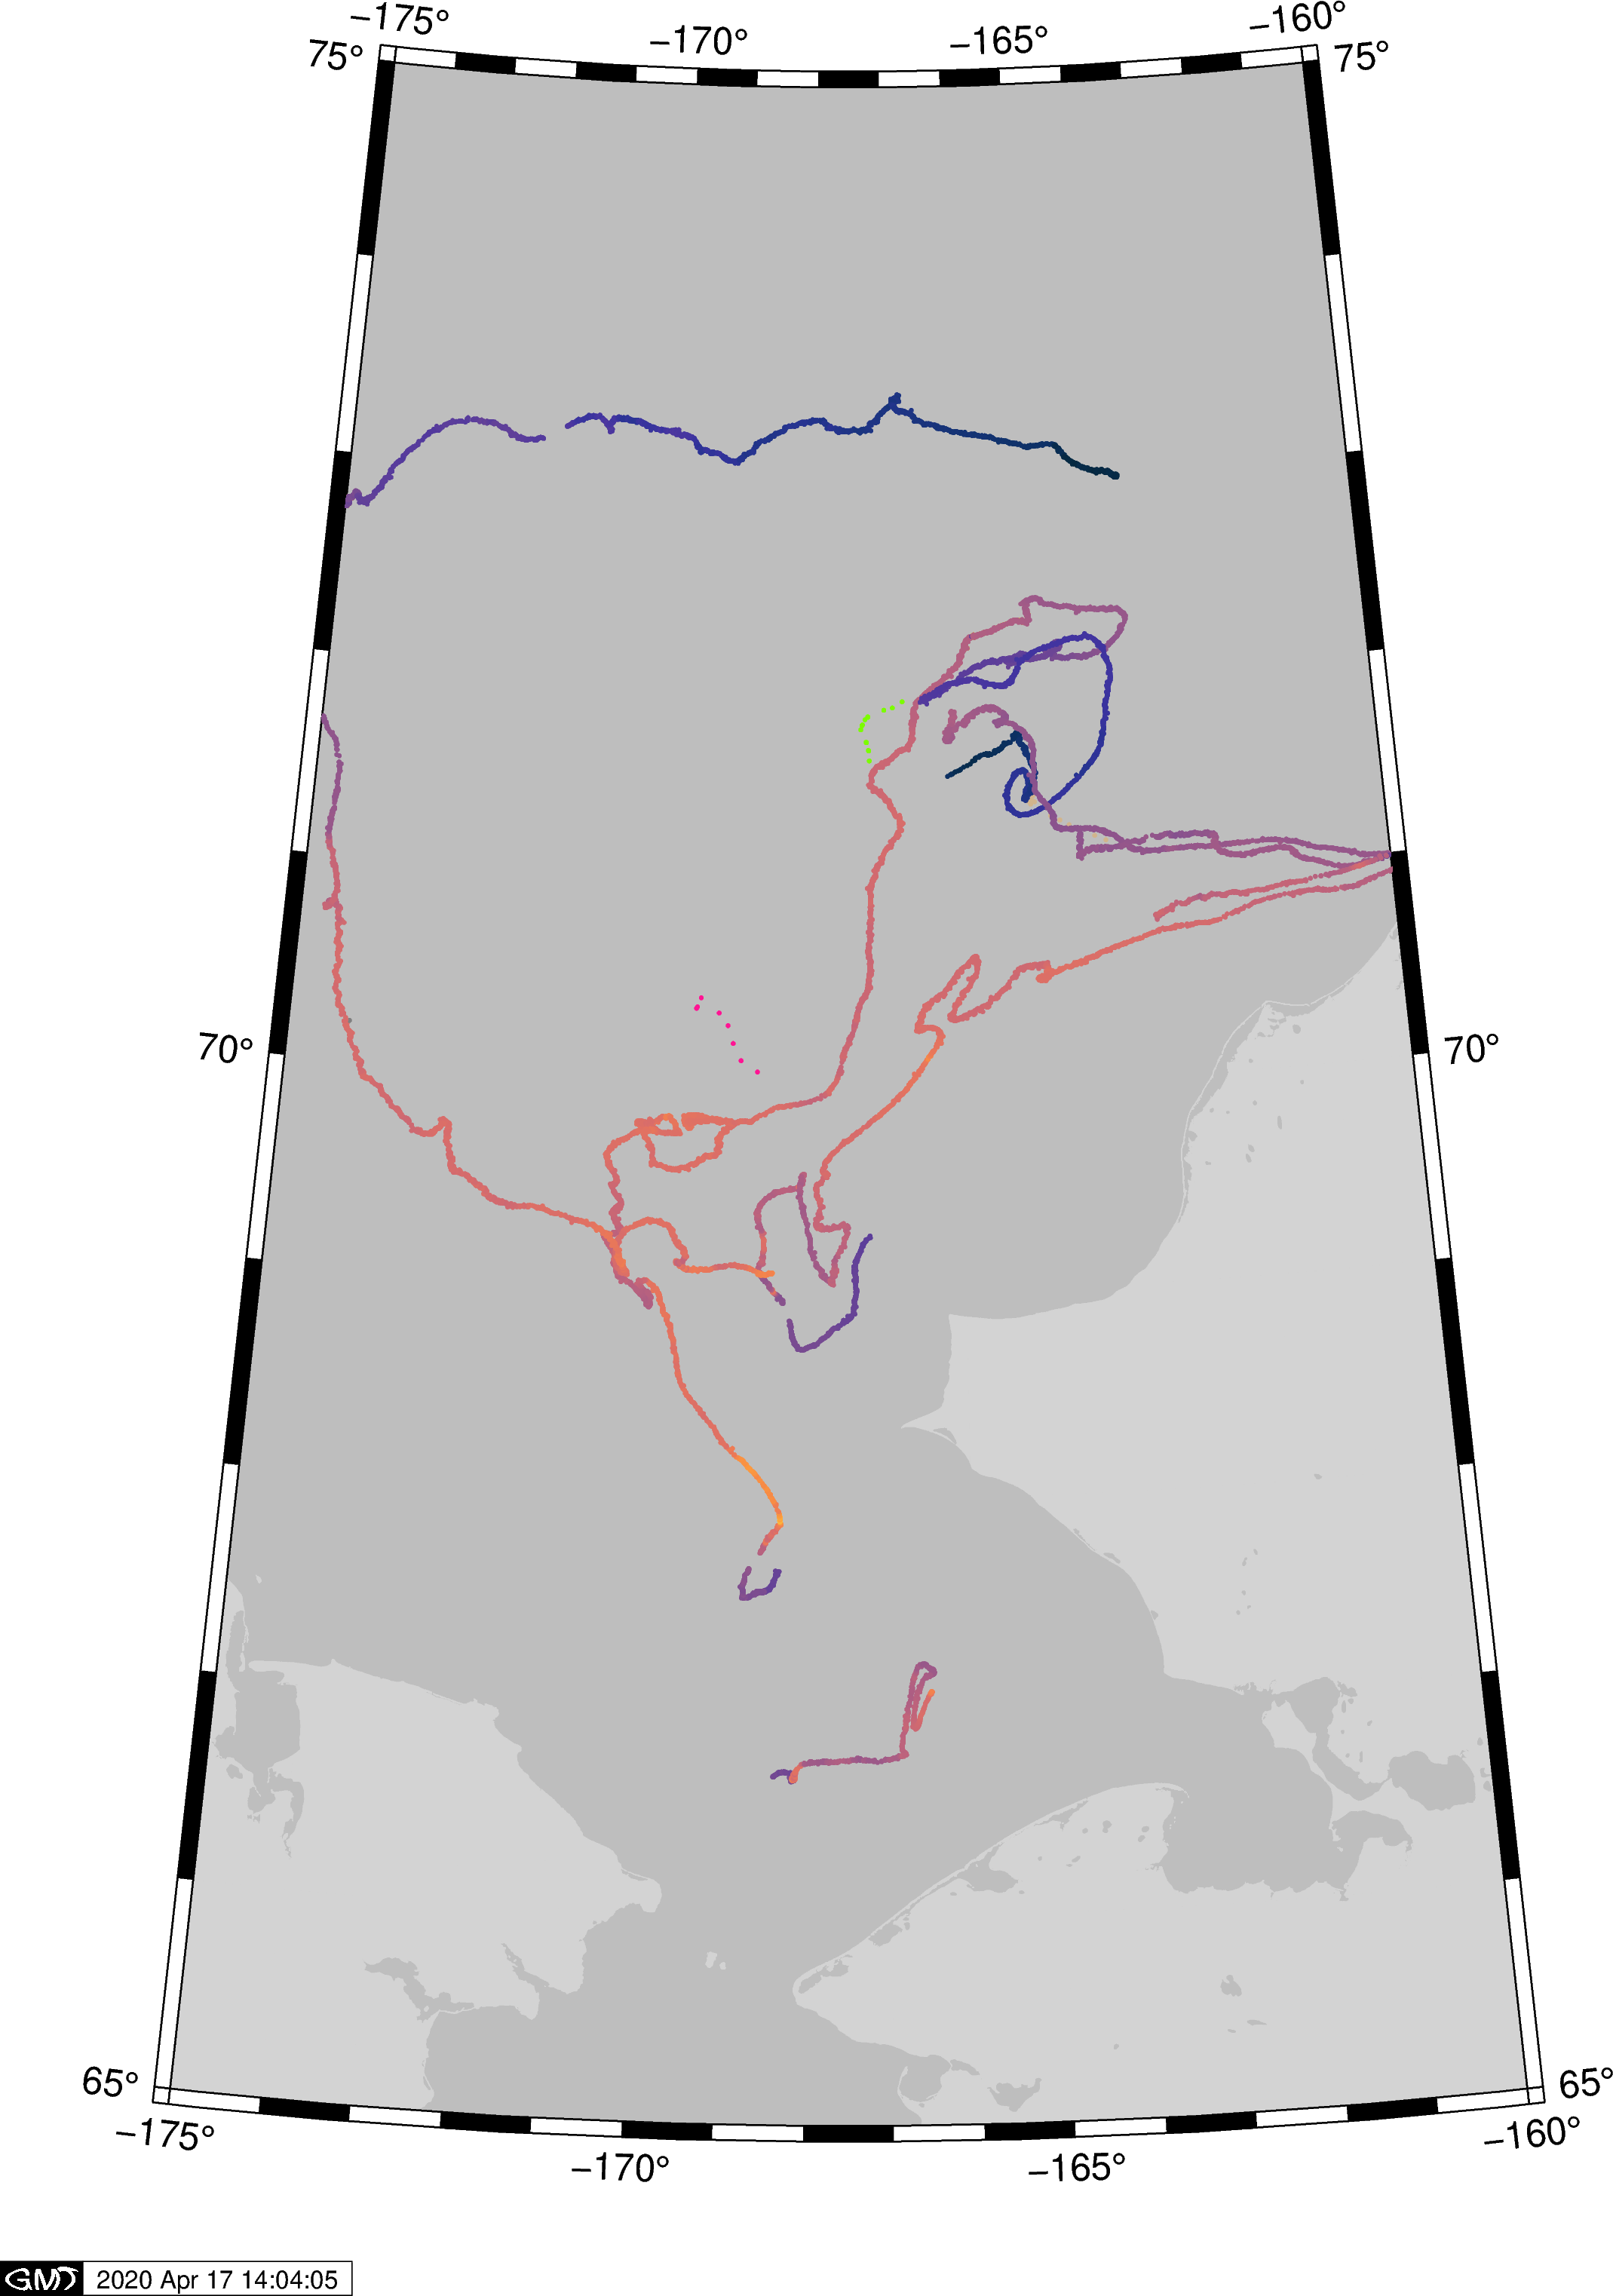

In [270]:
fig1.show()

## GMT - SST Bering

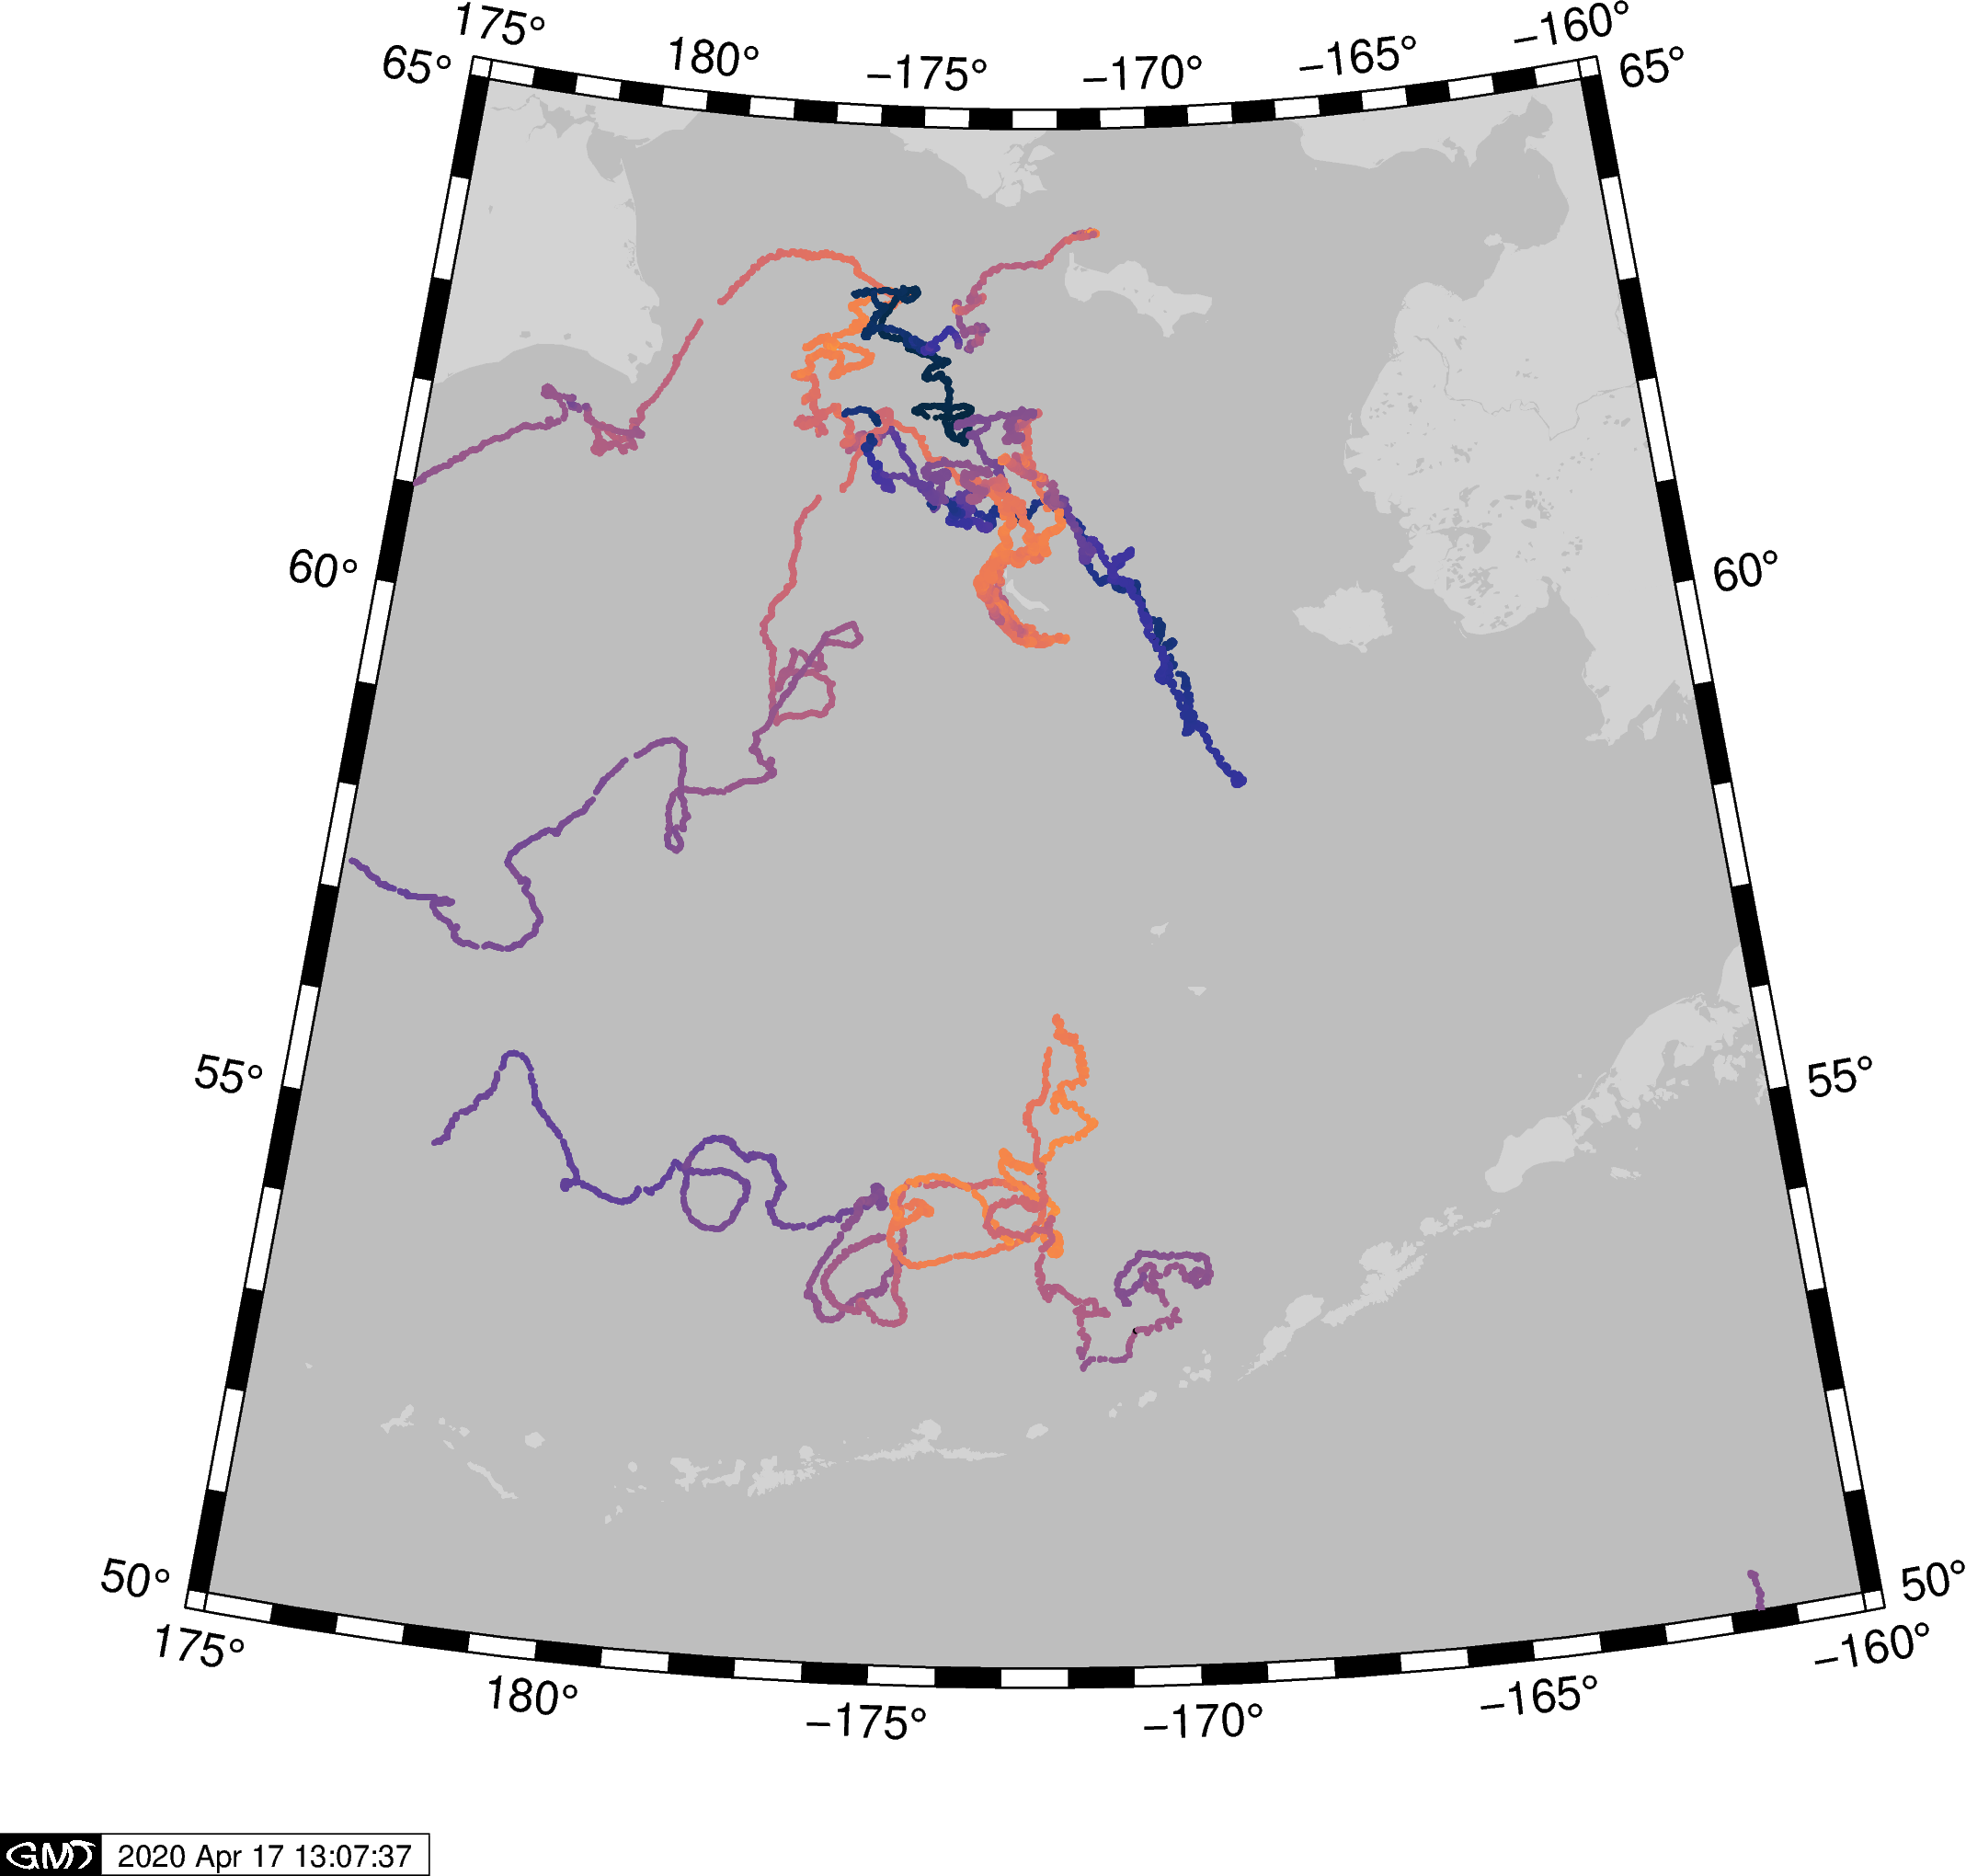

In [193]:
fig1b.show()

## GMT - DOY

In [267]:
float_color = {136863:'red',
                136866:'black',
                136867:'blue',
                136868:'green',
                139910:'cyan',
                139911:'yellow',
                139912:'orange',
                139913:'lightred',
                139914:'lightgray',
                139915:'lightblue',
                145469:'lightgreen',
                145473:'brown',
                145474:'darkgray',
                145480:'darkred',
                148276:'lightorange',
                'arctic_heat_alamo_profiles_11010':'deeppink',
                'arctic_heat_alamo_profiles_9150':'darkslateblue',
                'arctic_heat_alamo_profiles_9152':'lawngreen',
                'arctic_heat_alamo_profiles_9153':'dodgerblue',
                'arctic_heat_alamo_profiles_9199':'tan'
}

In [272]:
#color by doy and save each days image to make a move - 7 days of data max (so its a worm)
for ship, df in dfs_2.items():
    dfg=df.groupby('trajectory_id')

    #choose temp boundaries
    for dstep in range(0,65):

        fig1 = gmt.Figure()

        fig1.coast(region=[-175, -150, 65, 75], projection='B-162.5/60/55/60/6i', land='lightgray', water='gray',
              frame=True,U=False)

        stopdate=datetime.datetime.strftime(datetime.datetime(2018,8,1)+datetime.timedelta(days=dstep),
                                            '%Y-%m-%d')
        startdate=datetime.datetime.strftime(datetime.datetime(2018,8,1)+datetime.timedelta(days=dstep)-datetime.timedelta(days=7),
                                            '%Y-%m-%d')
        
        for traj in dfg.groups.keys():

            dfmiss = dfg.get_group(traj).resample('H').mean()[startdate:stopdate].copy()
            dfmiss['dayofyear'] = dfmiss.index.dayofyear
            if not dfmiss.empty:
                #dfmiss.dayofyear.loc[(df.dayofyear > 0) | (df.dayofyear < 366)] = np.nan
                # normalize data for colormap
                dfnorm = dfmiss.apply(lambda x: (x - (0)) / (366 - (0)))
                fig1.plot(x=dfmiss.longitude, y=dfmiss.latitude, color=float_color[traj], style='c0.05c')
                count +=1

        for alamo, df in dfs.items():
            dfmiss = df.resample('H').mean()[startdate:stopdate].copy()
            dfmiss['dayofyear'] = dfmiss.index.dayofyear
            if not dfmiss.empty:
                dfnorm = dfmiss.apply(lambda x: (x - (0)) / (366 - (0)))
                fig1.plot(x=dfmiss.longitude, y=dfmiss.latitude, color=float_color[alamo], style='c0.05c')
                count +=1

                fig1.savefig(stopdate + '.png')